In [2]:
import os
import math
from matplotlib.font_manager import FontProperties
import numpy as np
import pandas as pd

In [3]:
os.chdir('C:\\Users\\user\\Desktop\\PythonBook_code_data\\part4')

In [4]:
# 2001年1月 到 2014年2月 中國大陸月度CPI
CPI=pd.read_csv('C:\\Users\\user\\Desktop\\PythonBook_code_data\\part4\\025\\CPI.csv',index_col='time')
#轉換成時間序列格式
CPI.index=pd.to_datetime(CPI.index)
CPI.shape

(161, 1)

In [5]:
CPI.head(n=3)

,CPI
time,
2014-05-01,100.1
2014-04-01,99.7
2014-03-01,99.5


In [6]:
#序列後三個做為預測對照
CPI.tail(n=3)

,CPI
time,
2001-03-01,99.4
2001-02-01,100.2
2001-01-01,101.9


In [7]:
CPI=CPI.sort_index() #按日期排序
#選擇train data
CPItrain=CPI[:-3]
CPItrain.tail(n=3)

,CPI
time,
2013-12-01,100.3
2014-01-01,101.0
2014-02-01,100.5


In [8]:
#選擇test data
CPItest = CPI[-3:]
CPItest

,CPI
time,
2014-03-01,99.5
2014-04-01,99.7
2014-05-01,100.1


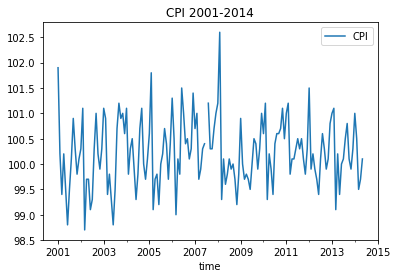

In [10]:
#繪製時序圖
CPI.plot(title='CPI 2001-2014')

定態，未明顯遞增遞減

In [11]:
# 對序列進行ADF單根檢定，判斷其定態性
# 載ADF函數
from arch.unitroot import ADF

In [12]:
#進行ADF單跟檢定，並檢視結果
#最大落後階數設為10
#防止使用的落後階數過多導致p=value偏低

CPItrain=CPItrain.dropna()
print(ADF(CPItrain,max_lags=10).summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.947
P-value                         0.040
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


統計量等於-2.947，小於5%顯著性水平下的臨界值-2.88，拒絕虛無假設，序列為定態 

判斷CPI序列是否為白雜訊序列，採LB檢定(Ljung-Box)

Ljung-Box 採用Q統計量

In [15]:
from statsmodels.tsa import stattools
LjungBox=stattools.q_stat(stattools.acf(CPItrain)[1:12],len(CPItrain))
LjungBox[1][-1] 

0.0005560128948515358

檢定的p值為0.000556<0.05，拒絕虛無假設，接受對立假設，認為CPI序列不是白雜訊序列。

2.模型識別與估計

採ARMA模型，識別參數p和q，利用ACF和PACF來判斷模型的具體形式。

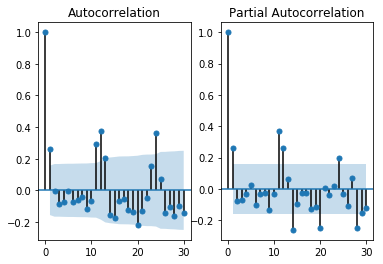

In [16]:
from statsmodels.graphics.tsaplots import *
import matplotlib.pyplot as plt
#將畫面一分為二
axe1=plt.subplot(121)
axe2=plt.subplot(122)
#在第一個畫面中畫出序列的自相關係數圖 
plot1=plot_acf(CPItrain,lags=30,ax=axe1)
#在第二個畫面中畫出序列的偏自相關係數圖
plot2=plot_pacf(CPItrain,lags=30,ax=axe2)

CPItrain的自相關和偏自相關係數圖

透過CPI訓練集序列的ACF和PACF圖，我們發現序列的自相關係數和偏自相關係數都呈現出拖尾的性質，因此可以初步判斷 p>0 , q>0。至於p和q的具體取值還無法判斷。因此考慮建立起低階p、q的各種組合情況下的ARMA模型，並運用AIC準則比較，選出AIC最小的模型。

In [18]:
from statsmodels.tsa import arima_model
#order表示建立的模型的階數，c(1,0,1)表示建立的是ARMA(1,1)模型；
#中間的數字0表示使用原始的、未進行過差分（差分次數為0）的數據；
#此處我們無需考慮它

model1=arima_model.ARIMA(CPItrain,order=(1,0,1)).fit()
model1.summary()

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    CPI   No. Observations:                  157
Model:                     ARMA(1, 1)   Log Likelihood                -150.339
Method:                       css-mle   S.D. of innovations              0.630
Date:                Sun, 15 Mar 2020   AIC                            308.678
Time:                        20:26:47   BIC                            320.903
Sample:                             0   HQIC                           313.643
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.2373      0.066   1516.139      0.000     100.108     100.367
ar.L1.CPI      0.0934      0.248      0.377      0.707      -0.392       0.579
ma.L1.CPI      0.1932      0.240      0.805      0.422      -0.277       0.664
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           10.7069           +0.0000j           10.7069            0.0000
MA.1           -5.1771           +0.0000j            5.1771            0.5000
-----------------------------------------------------------------------------
"""

In [19]:
#同理，我們建立起其它階數的模型
model2=arima_model.ARIMA(CPItrain,order=(1,0,2)).fit()
model2.summary()

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    CPI   No. Observations:                  157
Model:                     ARMA(1, 2)   Log Likelihood                -150.261
Method:                       css-mle   S.D. of innovations              0.630
Date:                Sun, 15 Mar 2020   AIC                            310.521
Time:                        20:27:28   BIC                            325.802
Sample:                             0   HQIC                           316.727
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.2375      0.067   1502.409      0.000     100.107     100.368
ar.L1.CPI     -0.2048      0.673     -0.304      0.761      -1.523       1.114
ma.L1.CPI      0.4956      0.667      0.743      0.459      -0.811       1.802
ma.L2.CPI      0.1054      0.199      0.531      0.596      -0.284       0.495
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -4.8833           +0.0000j            4.8833            0.5000
MA.1           -2.3501           -1.9904j            3.0797           -0.3882
MA.2           -2.3501           +1.9904j            3.0797            0.3882
-----------------------------------------------------------------------------
"""

In [20]:
model3=arima_model.ARIMA(CPItrain,order=(2,0,1)).fit()
model4=arima_model.ARIMA(CPItrain,order=(2,0,2)).fit()
model5=arima_model.ARIMA(CPItrain,order=(3,0,2)).fit()

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


模型   mod1     mod2    mod3    mod4    mod5   
(p,q) (1,1)    (1,2)   (2,1)   (2,2)   (3,1)
AIC值 308.678 310.521 307.933 309.271 308.496

In [31]:
AICpq = [{"(p,q)":'(1,1)',"模型":"mod1", "AIC值":308.678},
          {"(p,q)":'(1,2)',"模型":"mod2", "AIC值":310.521},
          {"(p,q)":'(2,1)',"模型":"mod3", "AIC值":307.933},
         {"(p,q)":'(2,2)',"模型":"mod4", "AIC值":309.271},
         {"(p,q)":'(3,1)',"模型":"mod5", "AIC值":308.496}]
AICpq_df = pd.DataFrame(AICpq)

In [32]:
AICpq_df

,"(p,q)",AIC值,模型
0,"(1,1)",308.678,mod1
1,"(1,2)",310.521,mod2
2,"(2,1)",307.933,mod3
3,"(2,2)",309.271,mod4
4,"(3,1)",308.496,mod5


ARMA(2,1)的AIC值為最小，故模型確定為ARMA(2,1)

3.模型診斷

對模型進行評價係數顯著性的檢定，殘差序列是否為白雜訊的檢定。
如果殘差序列是白雜訊，則說明模型已充分提取序列的資訊。我們無法再透過調整模型從資料中抓取更多的資訊，因而模型的建立是成功的。
如果殘差序列非白雜訊，則說明模型不完善且須對其進行修正。

In [33]:
#計算模型中係數的信賴區間
model3.conf_int()

,0,1
const,100.216756,100.286655
ar.L1.CPI,1.101874,1.404685
ar.L2.CPI,-0.458490,-0.146583
ma.L1.CPI,-1.039059,-0.960941


可以看到所有係數的信賴區間都不包含0，因此我們可以說在5%的信心水準下，
所有係數都是顯著的。

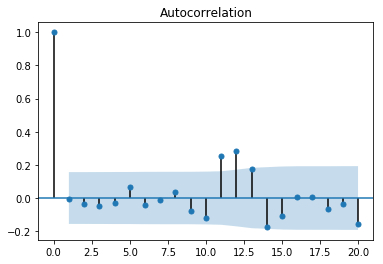

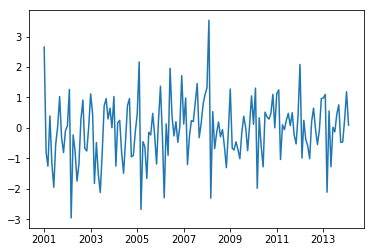

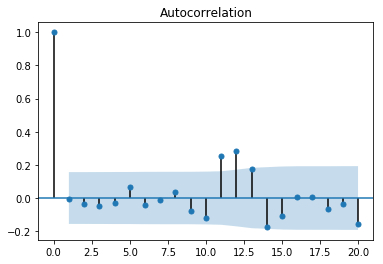

In [34]:
#對殘差序列的純隨機性的檢定
#繪製時間序列模擬的診斷圖
stdresid=model3.resid/math.sqrt(model3.sigma2)
plt.plot(stdresid)
plot_acf(stdresid,lags=20)

In [35]:
LjungBox=stattools.q_stat(stattools.acf(stdresid)[1:13],len(stdresid))
LjungBox[1][-1]

0.002646926487719565

In [36]:
#增加Ljung-Box檢定的落後階數
LjungBox=stattools.q_stat(stattools.acf(stdresid)[1:20],len(stdresid))
LjungBox[1][-1]

0.0008835795439016812

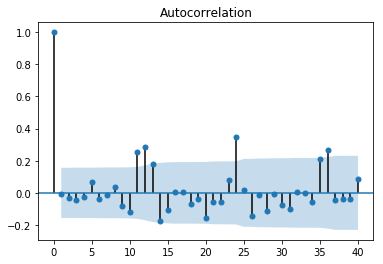

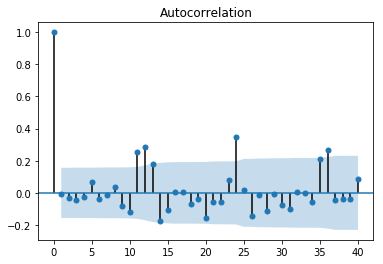

In [39]:
#繪製最大落後階數為40的自相關係數圖
plot_acf(stdresid,lags=40)

殘差基本上在+-3之間，沒有偏差值。但是在ACF圖中，第11階和第12階的字將關係數是顯著的。
因此，無法確定殘差是白雜訊序列。因此增加Ljung-Box檢定的落後階數。

在12階之後，檢定的p值都小於5%。因此模型的殘差並不是一個白雜訊序列。
如果將自相關係數圖的最大落後階數設為40，可以明顯地看到每隔12階自相關係數就會變得顯著。結果表明模型並沒有很好的擬合原資料，需要一個季節性ARIMA模型。

4.運用模型進行預測

用forcast()函數基於以上估計的模型對未來的序列值進行預測。

In [40]:
#用model3 預測未來3期的CPI
model3.forecast(3)[0]

array([100.27850928, 100.21017991, 100.19155321])

透過程式碼可得知，2014年3月4月5月的月度CPI預測值分別為
100.27850928, 100.21017991, 100.19155321。
為了比較預測結果，我們可以檢視原資料集中2014年3月4月5月的月度環比CPI的實際值。

In [41]:
CPI.head(3)
CPItest

,CPI
time,
2014-03-01,99.5
2014-04-01,99.7
2014-05-01,100.1
